### Q1 PySpark assesment

### 1. Setup a local environment to run PySpark.

In [1]:
import pyspark

import os
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder

from sklearn.datasets import make_classification
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix

from scipy.stats import chi2_contingency

import py4j

from pyspark.sql import Row
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext

from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.functions import udf
from pyspark.sql.functions import isnan, when, count, col

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import (VectorAssembler,VectorIndexer,
                                OneHotEncoder,StringIndexer,StandardScaler)
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator

from pyspark.ml import Pipeline

### Description of Census Dataset

**Abstract**

Abstract: This data set contains weighted census data extracted from the 1994 and 1995 current population surveys conducted by the U.S. Census Bureau.

**Information files:**

- <a href="http://kdd.ics.uci.edu/databases/census-income/census-income.data.html">description of the data</a>
- <a href="http://kdd.ics.uci.edu/databases/census-income/census-income.names">original names file</a>


**The <a href="http://archive.ics.uci.edu/ml/machine-learning-databases/census-income-mld/">dataset </a>contains three files:** 
- census-income.data: the training dataset
- census-income.names: dataset description
- census-income.test: test dataset

One instance per line with comma delimited fields. There are 199523 instances in the data file and 99762 in the test file.

The data was split into train/test in approximately 2/3, 1/3 proportions using MineSet's MIndUtil mineset-to-mlc.

We have two datasets available: training and testing. I assume that the "split" has been well done in terms of the performance of the future model. I will do data mining, column removal, cleaning and engineering **on both files.**

Feautures:
- age						AAGE
- class of worker				ACLSWKR
- industry code					ADTIND
- occupation code				ADTOCC
- adjusted gross income				AGI (there is no in dataset)
- education					AHGA
- wage per hour					AHRSPAY
- enrolled in edu inst last wk			AHSCOL
- marital status				AMARITL
- major industry code				AMJIND
- major occupation code				AMJOCC
- mace						ARACE
- hispanic Origin				AREORGN
- sex						ASEX
- member of a labor union			AUNMEM
- reason for unemployment			AUNTYPE
- full or part time employment stat		AWKSTAT
- capital gains					CAPGAIN
- capital losses				CAPLOSS
- dividends from stocks				DIVVAL
- federal income tax liability			FEDTAX (there is no in dataset)
- tax filer status				FILESTAT
- region of previous residence			GRINREG
- state of previous residence			GRINST
- detailed household and family stat		HHDFMX
- detailed household summary in household	HHDREL
- instance weight				MARSUPWT
- migration code-change in msa			MIGMTR1
- migration code-change in reg			MIGMTR3
- migration code-move within reg		MIGMTR4
- live in this house 1 year ago			MIGSAME
- migration prev res in sunbelt			MIGSUN
- num persons worked for employer		NOEMP
- family members under 18			PARENT
- total person earnings				PEARNVAL (there is no in dataset)
- country of birth father			PEFNTVTY
- country of birth mother			PEMNTVTY
- country of birth self				PENATVTY
- citizenship					PRCITSHP
- total person income				PTOTVAL (there is no in dataset)
- own business or self employed			SEOTR
- taxable income amount				TAXINC
- fill inc questionnaire for veteran's admin	VETQVA
- veterans benefits				VETYN
- weeks worked in year				WKSWORK

### Output variable (Target):
- income level (additionally)

### Build the SparkSession

In [2]:
spark = SparkSession.builder.master("local").appName("Question1").getOrCreate()

I had the problem with number of columns, because there were more in dataset then in descripton. 

### Load in the data

### 2. Download the Census Income data at http://archive.ics.uci.edu/ml/datasets/Census-Income+(KDD)  

In [3]:
df_train = spark.read.csv('census-income.data')
df_train

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string]

In [4]:
df_test = spark.read.csv('census-income.test')
df_test

DataFrame[_c0: string, _c1: string, _c2: string, _c3: string, _c4: string, _c5: string, _c6: string, _c7: string, _c8: string, _c9: string, _c10: string, _c11: string, _c12: string, _c13: string, _c14: string, _c15: string, _c16: string, _c17: string, _c18: string, _c19: string, _c20: string, _c21: string, _c22: string, _c23: string, _c24: string, _c25: string, _c26: string, _c27: string, _c28: string, _c29: string, _c30: string, _c31: string, _c32: string, _c33: string, _c34: string, _c35: string, _c36: string, _c37: string, _c38: string, _c39: string, _c40: string, _c41: string]

### Data Exploration

### 3. Print the data Schema, Summary, # of columns and # of rows.

In [5]:
df_train.show(1, vertical=True)

-RECORD 0--------------------
 _c0  | 73                   
 _c1  |  Not in universe     
 _c2  |  0                   
 _c3  |  0                   
 _c4  |  High school grad... 
 _c5  |  0                   
 _c6  |  Not in universe     
 _c7  |  Widowed             
 _c8  |  Not in universe ... 
 _c9  |  Not in universe     
 _c10 |  White               
 _c11 |  All other           
 _c12 |  Female              
 _c13 |  Not in universe     
 _c14 |  Not in universe     
 _c15 |  Not in labor force  
 _c16 |  0                   
 _c17 |  0                   
 _c18 |  0                   
 _c19 |  Nonfiler            
 _c20 |  Not in universe     
 _c21 |  Not in universe     
 _c22 |  Other Rel 18+ ev... 
 _c23 |  Other relative o... 
 _c24 |  1700.09             
 _c25 |  ?                   
 _c26 |  ?                   
 _c27 |  ?                   
 _c28 |  Not in universe ... 
 _c29 |  ?                   
 _c30 |  0                   
 _c31 |  Not in universe     
 _c32 |  U

In [6]:
df_train.printSchema()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: string (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)
 |-- _c5: string (nullable = true)
 |-- _c6: string (nullable = true)
 |-- _c7: string (nullable = true)
 |-- _c8: string (nullable = true)
 |-- _c9: string (nullable = true)
 |-- _c10: string (nullable = true)
 |-- _c11: string (nullable = true)
 |-- _c12: string (nullable = true)
 |-- _c13: string (nullable = true)
 |-- _c14: string (nullable = true)
 |-- _c15: string (nullable = true)
 |-- _c16: string (nullable = true)
 |-- _c17: string (nullable = true)
 |-- _c18: string (nullable = true)
 |-- _c19: string (nullable = true)
 |-- _c20: string (nullable = true)
 |-- _c21: string (nullable = true)
 |-- _c22: string (nullable = true)
 |-- _c23: string (nullable = true)
 |-- _c24: string (nullable = true)
 |-- _c25: string (nullable = true)
 |-- _c26: string (nullable = true)
 |-- _c27: string (nullable = tru

### Changing the name of columns

In the dataset description, some columns did not match. The description said that is 40 columns, but in real were 42. The actual data did not fit to describe. I had to identify and change the names of columns, but understand that it wouldn't be possible with huge numbers of columns. 
There were no be:  'adjusted gross income', 'federal income tax liability', 'total person earnings', 'total person income'. I had to add 'income level' column.

I thought it would be more convenient to explore the data by reading the real column names. Like:


newColumns = ['age','class of worker','industry code','occupation code', 
              'education', 'wage per hour','enrolled in edu inst last wk','marital status', 'major industry code', 
              'major occupation code', 'mace', 'hispanic Origin','sex', 'member of a labor union', 
              'reason for unemployment', 'full or part time employment stat', 'capital gains', 'capital losses', 
              'divdends from stocks','tax filer status',
              'region of previous residence', 'state of previous residence', 'detailed household and family stat', 
              'detailed household summary in household', 'instance weight','migration code-change in msa', 
              'migration code-change in reg', 'migration code-move within reg', 'live in this house 1 year ago', 
              'migration prev res in sunbelt','num persons worked for employer', 'family members under 18',
              'country of birth father', 'country of birth mother', 
              'country of birth self', 'citizenship', 'own business or self employed',
              "fill inc questionnaire for veteran's admin", 'veterans benefits', 
              'weeks worked in year','year', 'income label']
              


In [7]:
data_train = (df_train
    .withColumnRenamed('_c0','age')
    .withColumnRenamed('_c1','class of worker')
    .withColumnRenamed('_c2','industry code')
    .withColumnRenamed('_c3','occupation code') 
    .withColumnRenamed('_c4','education') 
    .withColumnRenamed('_c5','wage per hour')
    .withColumnRenamed('_c6','enrolled in edu inst last wk')
    .withColumnRenamed('_c7','marital status') 
    .withColumnRenamed('_c8','major industry code')
    .withColumnRenamed('_c9','major occupation code') 
    .withColumnRenamed('_c10','mace') 
    .withColumnRenamed('_c11','hispanic Origin')
    .withColumnRenamed('_c12','sex') 
    .withColumnRenamed('_c13','member of a labor union') 
    .withColumnRenamed('_c14','reason for unemployment') 
    .withColumnRenamed('_c15','full or part time employment stat') 
    .withColumnRenamed('_c16','capital gains') 
    .withColumnRenamed('_c17','capital losses') 
    .withColumnRenamed('_c18','dividends from stocks')
    .withColumnRenamed('_c19','tax filer status')
    .withColumnRenamed('_c20','region of previous residence') 
    .withColumnRenamed('_c21','state of previous residence') 
    .withColumnRenamed('_c22','detailed household and family stat') 
    .withColumnRenamed('_c23','detailed household summary in household') 
    .withColumnRenamed('_c24','instance weight')
    .withColumnRenamed('_c25','migration code-change in msa') 
    .withColumnRenamed('_c26','migration code-change in reg') 
    .withColumnRenamed('_c27','migration code-move within reg') 
    .withColumnRenamed('_c28','live in this house 1 year ago') 
    .withColumnRenamed('_c29','migration prev res in sunbelt')
    .withColumnRenamed('_c30','num persons worked for employer') 
    .withColumnRenamed('_c31','family members under 18')
    .withColumnRenamed('_c32','country of birth father') 
    .withColumnRenamed('_c33','country of birth mother') 
    .withColumnRenamed('_c34','country of birth self') 
    .withColumnRenamed('_c35','citizenship')
    .withColumnRenamed('_c36','own business or self employed')
    .withColumnRenamed('_c37',"fill inc questionnaire for veteran's admin") 
    .withColumnRenamed('_c38','veterans benefits') 
    .withColumnRenamed('_c39','weeks worked in year')
    .withColumnRenamed('_c40','year') 
    .withColumnRenamed('_c41','income label'))
                       
                       
data_train.printSchema()

root
 |-- age: string (nullable = true)
 |-- class of worker: string (nullable = true)
 |-- industry code: string (nullable = true)
 |-- occupation code: string (nullable = true)
 |-- education: string (nullable = true)
 |-- wage per hour: string (nullable = true)
 |-- enrolled in edu inst last wk: string (nullable = true)
 |-- marital status: string (nullable = true)
 |-- major industry code: string (nullable = true)
 |-- major occupation code: string (nullable = true)
 |-- mace: string (nullable = true)
 |-- hispanic Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member of a labor union: string (nullable = true)
 |-- reason for unemployment: string (nullable = true)
 |-- full or part time employment stat: string (nullable = true)
 |-- capital gains: string (nullable = true)
 |-- capital losses: string (nullable = true)
 |-- dividends from stocks: string (nullable = true)
 |-- tax filer status: string (nullable = true)
 |-- region of previous residence: strin

In [8]:
data_test = (df_train
    .withColumnRenamed('_c0','age')
    .withColumnRenamed('_c1','class of worker')
    .withColumnRenamed('_c2','industry code')
    .withColumnRenamed('_c3','occupation code') 
    .withColumnRenamed('_c4','education') 
    .withColumnRenamed('_c5','wage per hour')
    .withColumnRenamed('_c6','enrolled in edu inst last wk')
    .withColumnRenamed('_c7','marital status') 
    .withColumnRenamed('_c8','major industry code')
    .withColumnRenamed('_c9','major occupation code') 
    .withColumnRenamed('_c10','mace') 
    .withColumnRenamed('_c11','hispanic Origin')
    .withColumnRenamed('_c12','sex') 
    .withColumnRenamed('_c13','member of a labor union') 
    .withColumnRenamed('_c14','reason for unemployment') 
    .withColumnRenamed('_c15','full or part time employment stat') 
    .withColumnRenamed('_c16','capital gains') 
    .withColumnRenamed('_c17','capital losses') 
    .withColumnRenamed('_c18','dividends from stocks')
    .withColumnRenamed('_c19','tax filer status')
    .withColumnRenamed('_c20','region of previous residence') 
    .withColumnRenamed('_c21','state of previous residence') 
    .withColumnRenamed('_c22','detailed household and family stat') 
    .withColumnRenamed('_c23','detailed household summary in household') 
    .withColumnRenamed('_c24','instance weight')
    .withColumnRenamed('_c25','migration code-change in msa') 
    .withColumnRenamed('_c26','migration code-change in reg') 
    .withColumnRenamed('_c27','migration code-move within reg') 
    .withColumnRenamed('_c28','live in this house 1 year ago') 
    .withColumnRenamed('_c29','migration prev res in sunbelt')
    .withColumnRenamed('_c30','num persons worked for employer') 
    .withColumnRenamed('_c31','family members under 18')
    .withColumnRenamed('_c32','country of birth father') 
    .withColumnRenamed('_c33','country of birth mother') 
    .withColumnRenamed('_c34','country of birth self') 
    .withColumnRenamed('_c35','citizenship')
    .withColumnRenamed('_c36','own business or self employed')
    .withColumnRenamed('_c37',"fill inc questionnaire for veteran's admin") 
    .withColumnRenamed('_c38','veterans benefits') 
    .withColumnRenamed('_c39','weeks worked in year')
    .withColumnRenamed('_c40','year') 
    .withColumnRenamed('_c41','income label'))
                       
                       
data_test.printSchema()

root
 |-- age: string (nullable = true)
 |-- class of worker: string (nullable = true)
 |-- industry code: string (nullable = true)
 |-- occupation code: string (nullable = true)
 |-- education: string (nullable = true)
 |-- wage per hour: string (nullable = true)
 |-- enrolled in edu inst last wk: string (nullable = true)
 |-- marital status: string (nullable = true)
 |-- major industry code: string (nullable = true)
 |-- major occupation code: string (nullable = true)
 |-- mace: string (nullable = true)
 |-- hispanic Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member of a labor union: string (nullable = true)
 |-- reason for unemployment: string (nullable = true)
 |-- full or part time employment stat: string (nullable = true)
 |-- capital gains: string (nullable = true)
 |-- capital losses: string (nullable = true)
 |-- dividends from stocks: string (nullable = true)
 |-- tax filer status: string (nullable = true)
 |-- region of previous residence: strin

In [9]:
schema = [StructField('age', FloatType(), True),
               
               StructField('class of worker', StringType(), True),
               StructField('industry code', StringType(), True),
               StructField('occupation code', StringType(), True),
               StructField('education', StringType(), True),
               
               StructField('wage per hour', FloatType(), True),
               
               StructField('enrolled in edu inst last wk', StringType(), True),
               StructField('marital status', StringType(), True),
               StructField('major industry code', StringType(), True),
               StructField('major occupation code', StringType(), True),
               StructField('mace', StringType(), True),
               StructField('hispanic Origin', StringType(), True),
               StructField('sex', StringType(), True),
               StructField('member of a labor union', StringType(), True),
               StructField('reason for unemployment', StringType(), True),
               StructField('full or part time employment stat', StringType(), True),
               
               StructField('capital gains', FloatType(), True),
               StructField('capital losses', FloatType(), True),
               StructField('dividends from stocks', FloatType(), True),
              
               StructField('tax filer status', StringType(), True),
               StructField('region of previous residence', StringType(), True),
               StructField('state of previous residence', StringType(), True),
               StructField('detailed household and family stat', StringType(), True),
               StructField('detailed household summary in household', StringType(), True),
               
               StructField('instance weight', FloatType(), True),
               
               StructField('migration code-change in msa', StringType(), True),
               StructField('migration code-change in reg', StringType(), True),
               StructField('migration code-move within reg', StringType(), True),
               StructField('live in this house 1 year ago', StringType(), True),
               StructField('migration prev res in sunbelt', StringType(), True),
               
               StructField('num persons worked for employer', FloatType(), True),
               
               StructField('family members under 18', StringType(), True),
               StructField('country of birth father', StringType(), True),
               StructField('country of birth mother', StringType(), True),
               StructField('country of birth self', StringType(), True),
               StructField('citizenship', StringType(), True),
               StructField('own business or self employed', StringType(), True),
               StructField("fill inc questionnaire for veteran's admin", StringType(), True),
               StructField('veterans benefits', StringType(), True),
               
               StructField('weeks worked in year', FloatType(), True), 
               
               StructField('year', StringType(), True),
               StructField('income label', StringType(), True)]

In [10]:
final_struc = StructType(fields=schema)

In [11]:
data_train = spark.read.csv('census-income.data', schema=final_struc)
data_train.printSchema()

root
 |-- age: float (nullable = true)
 |-- class of worker: string (nullable = true)
 |-- industry code: string (nullable = true)
 |-- occupation code: string (nullable = true)
 |-- education: string (nullable = true)
 |-- wage per hour: float (nullable = true)
 |-- enrolled in edu inst last wk: string (nullable = true)
 |-- marital status: string (nullable = true)
 |-- major industry code: string (nullable = true)
 |-- major occupation code: string (nullable = true)
 |-- mace: string (nullable = true)
 |-- hispanic Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member of a labor union: string (nullable = true)
 |-- reason for unemployment: string (nullable = true)
 |-- full or part time employment stat: string (nullable = true)
 |-- capital gains: float (nullable = true)
 |-- capital losses: float (nullable = true)
 |-- dividends from stocks: float (nullable = true)
 |-- tax filer status: string (nullable = true)
 |-- region of previous residence: string (nu

In [12]:
data_test = spark.read.csv('census-income.test', schema=final_struc)
data_test.printSchema()

root
 |-- age: float (nullable = true)
 |-- class of worker: string (nullable = true)
 |-- industry code: string (nullable = true)
 |-- occupation code: string (nullable = true)
 |-- education: string (nullable = true)
 |-- wage per hour: float (nullable = true)
 |-- enrolled in edu inst last wk: string (nullable = true)
 |-- marital status: string (nullable = true)
 |-- major industry code: string (nullable = true)
 |-- major occupation code: string (nullable = true)
 |-- mace: string (nullable = true)
 |-- hispanic Origin: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- member of a labor union: string (nullable = true)
 |-- reason for unemployment: string (nullable = true)
 |-- full or part time employment stat: string (nullable = true)
 |-- capital gains: float (nullable = true)
 |-- capital losses: float (nullable = true)
 |-- dividends from stocks: float (nullable = true)
 |-- tax filer status: string (nullable = true)
 |-- region of previous residence: string (nu

In [13]:
print('Number of rows:',data_train.count()) 
print('Number of columns:',len(data_train.columns))

Number of rows: 199523
Number of columns: 42


In [14]:
print('Number of rows:',data_test.count()) 
print('Number of columns:',len(data_test.columns))

Number of rows: 99762
Number of columns: 42


### 4. Print a table that distinct values of all columns.

In the sections below I will display code only on data_train, but if it would be nessecery I change data_test also. 

In [15]:
data_train.columns

['age',
 'class of worker',
 'industry code',
 'occupation code',
 'education',
 'wage per hour',
 'enrolled in edu inst last wk',
 'marital status',
 'major industry code',
 'major occupation code',
 'mace',
 'hispanic Origin',
 'sex',
 'member of a labor union',
 'reason for unemployment',
 'full or part time employment stat',
 'capital gains',
 'capital losses',
 'dividends from stocks',
 'tax filer status',
 'region of previous residence',
 'state of previous residence',
 'detailed household and family stat',
 'detailed household summary in household',
 'instance weight',
 'migration code-change in msa',
 'migration code-change in reg',
 'migration code-move within reg',
 'live in this house 1 year ago',
 'migration prev res in sunbelt',
 'num persons worked for employer',
 'family members under 18',
 'country of birth father',
 'country of birth mother',
 'country of birth self',
 'citizenship',
 'own business or self employed',
 "fill inc questionnaire for veteran's admin",
 'vet

In [16]:
data_train.distinct().show()

+----+-----------------+-------------+---------------+--------------------+-------------+----------------------------+--------------------+--------------------+---------------------+------+-------------------+-------+-----------------------+-----------------------+---------------------------------+-------------+--------------+---------------------+--------------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+---------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+--------------------+-----------------------------+------------------------------------------+-----------------+--------------------+----+------------+
| age|  class of worker|industry code|occupation code|

In [17]:
data_train.select('age','class of worker','industry code','occupation code','education', 'wage per hour').distinct().show()

+----+--------------------+-------------+---------------+--------------------+-------------+
| age|     class of worker|industry code|occupation code|           education|wage per hour|
+----+--------------------+-------------+---------------+--------------------+-------------+
| 0.0|     Not in universe|            0|              0|            Children|          0.0|
|35.0|             Private|           25|             26| Associates degre...|          0.0|
|28.0|     Not in universe|            0|              0| High school grad...|          0.0|
|49.0| Self-employed-in...|           35|             16| Bachelors degree...|          0.0|
|30.0|             Private|           43|             10| Bachelors degree...|          0.0|
|31.0|             Private|           41|              8| Bachelors degree...|          0.0|
|44.0|             Private|           21|             21|          10th grade|          0.0|
|47.0|             Private|           35|             23| High school 

In [18]:
data_train.select('enrolled in edu inst last wk','marital status', 'major industry code','major occupation code').distinct().show()

+----------------------------+--------------------+--------------------+---------------------+
|enrolled in edu inst last wk|      marital status| major industry code|major occupation code|
+----------------------------+--------------------+--------------------+---------------------+
|             Not in universe|            Divorced|        Construction|  Precision produc...|
|             Not in universe|           Separated|      Communications|  Precision produc...|
|             Not in universe|       Never married| Manufacturing-no...|  Transportation a...|
|             Not in universe| Married-civilian...| Private househol...|  Farming forestry...|
|                 High school|       Never married|   Hospital services|        Other service|
|                 High school|       Never married| Public administr...|        Other service|
|         College or unive...|       Never married| Manufacturing-du...|  Adm support incl...|
|             Not in universe|       Never married

In [19]:
data_train.select('mace', 'hispanic Origin','sex', 'member of a labor union', 
'reason for unemployment').distinct().show()

+--------------------+--------------------+-------+-----------------------+-----------------------+
|                mace|     hispanic Origin|    sex|member of a labor union|reason for unemployment|
+--------------------+--------------------+-------+-----------------------+-----------------------+
|               Other| Central or South...| Female|                     No|        Not in universe|
|               Black|        Puerto Rican|   Male|        Not in universe|        Other job loser|
| Amer Indian Aleu...|           All other|   Male|        Not in universe|        Not in universe|
|               Other|             Chicano| Female|        Not in universe|        Not in universe|
| Asian or Pacific...|           All other|   Male|        Not in universe|             Job leaver|
|               Other|       Other Spanish| Female|        Not in universe|        Other job loser|
|               Other|        Puerto Rican|   Male|                    Yes|        Not in universe|


In [20]:
data_train.select( 'full or part time employment stat', 'capital gains', 'capital losses', 
'dividends from stocks','tax filer status').distinct().show()

+---------------------------------+-------------+--------------+---------------------+--------------------+
|full or part time employment stat|capital gains|capital losses|dividends from stocks|    tax filer status|
+---------------------------------+-------------+--------------+---------------------+--------------------+
|              Full-time schedules|       1831.0|           0.0|                  0.0|   Head of household|
|              Children or Arme...|          0.0|           0.0|              24000.0|              Single|
|               Not in labor force|          0.0|           0.0|                  1.0|            Nonfiler|
|              Full-time schedules|          0.0|           0.0|              27700.0| Joint one under ...|
|              Children or Arme...|          0.0|        1980.0|                 14.0|              Single|
|               Not in labor force|          0.0|        1887.0|                300.0| Joint both under 65|
|              Children or A

In [21]:
data_train.select('region of previous residence', 'state of previous residence', 'detailed household and family stat','detailed household summary in household', ).distinct().show()

+----------------------------+---------------------------+----------------------------------+---------------------------------------+
|region of previous residence|state of previous residence|detailed household and family stat|detailed household summary in household|
+----------------------------+---------------------------+----------------------------------+---------------------------------------+
|                       South|                       Utah|               Child <18 ever m...|                    Child under 18 e...|
|                   Northeast|                   Michigan|               RP of unrelated ...|                    Nonrelative of h...|
|                   Northeast|                   Michigan|               Child <18 never ...|                    Child under 18 n...|
|                     Midwest|                   Kentucky|                       Householder|                            Householder|
|                     Midwest|                  Tennessee|    

In [22]:
data_train.select('instance weight','migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg').distinct().show()

+---------------+----------------------------+----------------------------+------------------------------+
|instance weight|migration code-change in msa|migration code-change in reg|migration code-move within reg|
+---------------+----------------------------+----------------------------+------------------------------+
|        1060.36|                           ?|                           ?|                             ?|
|          934.7|                           ?|                           ?|                             ?|
|        1025.84|                           ?|                           ?|                             ?|
|          565.9|                    Nonmover|                    Nonmover|                      Nonmover|
|        1933.44|                    Nonmover|                    Nonmover|                      Nonmover|
|        2281.67|                           ?|                           ?|                             ?|
|        1559.29|                    

In [23]:
data_train.select('live in this house 1 year ago', 
'migration prev res in sunbelt','num persons worked for employer', 'family members under 18').distinct().show()

+-----------------------------+-----------------------------+-------------------------------+-----------------------+
|live in this house 1 year ago|migration prev res in sunbelt|num persons worked for employer|family members under 18|
+-----------------------------+-----------------------------+-------------------------------+-----------------------+
|                           No|                           No|                            1.0|    Father only present|
|          Not in universe ...|                            ?|                            6.0|    Both parents pre...|
|          Not in universe ...|                            ?|                            2.0|    Both parents pre...|
|                           No|                          Yes|                            6.0|    Neither parent p...|
|                           No|                          Yes|                            2.0|    Mother only present|
|                          Yes|              Not in univ

In [24]:
data_train.select('country of birth father', 'country of birth mother','country of birth self', 'citizenship').distinct().show()

+-----------------------+-----------------------+---------------------+--------------------+
|country of birth father|country of birth mother|country of birth self|         citizenship|
+-----------------------+-----------------------+---------------------+--------------------+
|            Philippines|                      ?|          Philippines| Foreign born- No...|
|     Holand-Netherlands|     Holand-Netherlands|                    ?| Foreign born- No...|
|                Ecuador|                      ?|                    ?| Native- Born abr...|
|                 Greece|                Germany|              Germany| Foreign born- No...|
|               Cambodia|                Vietnam|             Cambodia| Foreign born- U ...|
|                      ?|                   Cuba|   Dominican-Republic| Foreign born- U ...|
|                Ireland|                England|              England| Foreign born- No...|
|              Hong Kong|          United-States|        United-States

In [25]:
data_train.select('own business or self employed',
"fill inc questionnaire for veteran's admin", 'veterans benefits').distinct().show()

+-----------------------------+------------------------------------------+-----------------+
|own business or self employed|fill inc questionnaire for veteran's admin|veterans benefits|
+-----------------------------+------------------------------------------+-----------------+
|                            0|                                       Yes|                1|
|                            2|                                       Yes|                1|
|                            0|                           Not in universe|                0|
|                            1|                                        No|                1|
|                            0|                           Not in universe|                2|
|                            1|                                       Yes|                1|
|                            1|                           Not in universe|                2|
|                            2|                                       

In [26]:
data_train.select('weeks worked in year','year', 'income label').distinct().show()

+--------------------+----+------------+
|weeks worked in year|year|income label|
+--------------------+----+------------+
|                15.0|  94|     50000+.|
|                18.0|  94|     50000+.|
|                14.0|  95|    - 50000.|
|                30.0|  94|    - 50000.|
|                49.0|  94|    - 50000.|
|                50.0|  95|     50000+.|
|                49.0|  95|     50000+.|
|                42.0|  95|     50000+.|
|                 4.0|  95|     50000+.|
|                38.0|  95|    - 50000.|
|                 8.0|  95|    - 50000.|
|                43.0|  95|     50000+.|
|                46.0|  95|    - 50000.|
|                30.0|  94|     50000+.|
|                12.0|  95|     50000+.|
|                 2.0|  94|     50000+.|
|                 6.0|  95|    - 50000.|
|                51.0|  94|    - 50000.|
|                52.0|  94|    - 50000.|
|                24.0|  95|     50000+.|
+--------------------+----+------------+
only showing top

### 5. Make exploratory data analysis and visualize your findings from data.

In [27]:
type(data_train)

pyspark.sql.dataframe.DataFrame

In [28]:
data_train.dtypes

[('age', 'float'),
 ('class of worker', 'string'),
 ('industry code', 'string'),
 ('occupation code', 'string'),
 ('education', 'string'),
 ('wage per hour', 'float'),
 ('enrolled in edu inst last wk', 'string'),
 ('marital status', 'string'),
 ('major industry code', 'string'),
 ('major occupation code', 'string'),
 ('mace', 'string'),
 ('hispanic Origin', 'string'),
 ('sex', 'string'),
 ('member of a labor union', 'string'),
 ('reason for unemployment', 'string'),
 ('full or part time employment stat', 'string'),
 ('capital gains', 'float'),
 ('capital losses', 'float'),
 ('dividends from stocks', 'float'),
 ('tax filer status', 'string'),
 ('region of previous residence', 'string'),
 ('state of previous residence', 'string'),
 ('detailed household and family stat', 'string'),
 ('detailed household summary in household', 'string'),
 ('instance weight', 'float'),
 ('migration code-change in msa', 'string'),
 ('migration code-change in reg', 'string'),
 ('migration code-move within reg

#### A descripiton only for continuous variables

In [29]:
data_train.describe('age','wage per hour').show()

+-------+------------------+------------------+
|summary|               age|     wage per hour|
+-------+------------------+------------------+
|  count|            199523|            199523|
|   mean|34.494198663813194|55.426908175999756|
| stddev|22.310895206650155| 274.8964539028402|
|    min|               0.0|               0.0|
|    max|              90.0|            9999.0|
+-------+------------------+------------------+



In [30]:
data_train.describe('capital gains', 'capital losses','dividends from stocks').show()

+-------+-----------------+------------------+---------------------+
|summary|    capital gains|    capital losses|dividends from stocks|
+-------+-----------------+------------------+---------------------+
|  count|           199523|            199523|               199523|
|   mean|434.7189897906507|37.313788385298935|   197.52953293605248|
| stddev| 4697.53127971253| 271.8964283649649|   1984.1636583823397|
|    min|              0.0|               0.0|                  0.0|
|    max|          99999.0|            4608.0|              99999.0|
+-------+-----------------+------------------+---------------------+



In [31]:
data_train.describe('instance weight','num persons worked for employer').show()

+-------+------------------+-------------------------------+
|summary|   instance weight|num persons worked for employer|
+-------+------------------+-------------------------------+
|  count|            199523|                         199523|
|   mean|1740.3802694451635|             1.9561804904697704|
| stddev| 993.7681559908557|             2.3651255054923803|
|    min|             37.87|                            0.0|
|    max|           18656.3|                            6.0|
+-------+------------------+-------------------------------+



#### Missing values

In [32]:
data_train.select([count(when(isnan(c), c)).alias(c) for c in data_train.columns]).show()

+---+---------------+-------------+---------------+---------+-------------+----------------------------+--------------+-------------------+---------------------+----+---------------+---+-----------------------+-----------------------+---------------------------------+-------------+--------------+---------------------+----------------+----------------------------+---------------------------+----------------------------------+---------------------------------------+---------------+----------------------------+----------------------------+------------------------------+-----------------------------+-----------------------------+-------------------------------+-----------------------+-----------------------+-----------------------+---------------------+-----------+-----------------------------+------------------------------------------+-----------------+--------------------+----+------------+
|age|class of worker|industry code|occupation code|education|wage per hour|enrolled in edu inst la

#### We read in description: 
"The instance weight indicates the number of people in the population
that each record represents due to stratified sampling.
To do real analysis and derive conclusions, this field must be used.
This attribute should **not** be used in the classifiers, so it is
set to "ignore" in this file."

In [33]:
data_train = data_train.drop('instance weight')

data_test = data_test.drop('instance weight')

In [34]:
data_train.persist()

data_test.persist()

DataFrame[age: float, class of worker: string, industry code: string, occupation code: string, education: string, wage per hour: float, enrolled in edu inst last wk: string, marital status: string, major industry code: string, major occupation code: string, mace: string, hispanic Origin: string, sex: string, member of a labor union: string, reason for unemployment: string, full or part time employment stat: string, capital gains: float, capital losses: float, dividends from stocks: float, tax filer status: string, region of previous residence: string, state of previous residence: string, detailed household and family stat: string, detailed household summary in household: string, migration code-change in msa: string, migration code-change in reg: string, migration code-move within reg: string, live in this house 1 year ago: string, migration prev res in sunbelt: string, num persons worked for employer: float, family members under 18: string, country of birth father: string, country of b

#### I will change dataset to Pandas DataFrame to explore i vizualize a data. 

In [35]:
data_train_pandas = data_train.toPandas()

data_test_pandas = data_test.toPandas()

In [36]:
data_train_pandas.head()

,age,class of worker,industry code,occupation code,education,wage per hour,enrolled in edu inst last wk,marital status,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,income label
0,73.0,Not in universe,0,0,High school graduate,0.0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0.0,95,- 50000.
1,58.0,Self-employed-not incorporated,4,34,Some college but no degree,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52.0,94,- 50000.
2,18.0,Not in universe,0,0,10th grade,0.0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0.0,95,- 50000.
3,9.0,Not in universe,0,0,Children,0.0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,94,- 50000.
4,10.0,Not in universe,0,0,Children,0.0,Not in universe,Never married,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,94,- 50000.


In [37]:
# Alternative counting of missing values

data_train_pandas.isna().sum()

age                                           0
class of worker                               0
industry code                                 0
occupation code                               0
education                                     0
wage per hour                                 0
enrolled in edu inst last wk                  0
marital status                                0
major industry code                           0
major occupation code                         0
mace                                          0
hispanic Origin                               0
sex                                           0
member of a labor union                       0
reason for unemployment                       0
full or part time employment stat             0
capital gains                                 0
capital losses                                0
dividends from stocks                         0
tax filer status                              0
region of previous residence            

In [38]:
# describe on data_train

round(data_train_pandas.describe(),2)

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,199523.00,199523.00,199523.00,199523.00,199523.00,199523.00,199523.00
mean,34.49,55.43,434.72,37.31,197.53,1.96,23.17
std,22.31,274.90,4697.53,271.90,1984.16,2.37,24.41
min,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,15.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,33.00,0.00,0.00,0.00,0.00,1.00,8.00
75%,50.00,0.00,0.00,0.00,0.00,4.00,52.00
max,90.00,9999.00,99999.00,4608.00,99999.00,6.00,52.00


#### Data Outliers

I am going to find the outliers and number of them in numerical columns. 
After it I will change the values on median or mean of all values

To identifying extreme values in the tails of the distribution I use IQR. This is a measure of variability, based on dividing a data set into quartiles. Quartiles divide a rank-ordered data set into four equal parts. The values that separate parts are called the first, second, and third quartiles; and they are denoted by Q1, Q2, and Q3, respectively.

The interquartile range is often used to find outliers in data. Outliers here are defined as observations that fall below Q1 − 1.5 IQR or above Q3 + 1.5 IQR. 

Source: https://en.wikipedia.org/wiki/Interquartile_range

In [39]:
Q1 = data_train_pandas.quantile(0.25)
Q3 = data_train_pandas.quantile(0.75)
IQR = Q3 - Q1

data_train_amnt = pd.DataFrame({'Q1':Q1, 'Q3':Q3,'IQR':IQR, 'lower': Q1-1.5*IQR, 'upper': Q3+1.5*IQR,
                 'number of Outliers' : ((data_train_pandas < (Q1 - 1.5 * IQR)) | (data_train_pandas > (Q3 + 1.5 * IQR))).sum(),
                })

data_train_amnt

,Q1,Q3,IQR,lower,upper,number of Outliers
age,15.0,50.0,35.0,-37.5,102.5,0
capital gains,0.0,0.0,0.0,0.0,0.0,7379
capital losses,0.0,0.0,0.0,0.0,0.0,3906
citizenship,NaN,NaN,NaN,NaN,NaN,0
class of worker,NaN,NaN,NaN,NaN,NaN,0
country of birth father,NaN,NaN,NaN,NaN,NaN,0
country of birth mother,NaN,NaN,NaN,NaN,NaN,0
country of birth self,NaN,NaN,NaN,NaN,NaN,0
detailed household and family stat,NaN,NaN,NaN,NaN,NaN,0
detailed household summary in household,NaN,NaN,NaN,NaN,NaN,0


In [40]:
for col_name in data_train_pandas[['capital gains','capital losses','dividends from stocks','wage per hour']]:
    q1 = data_train_pandas[col_name].quantile(0.25)
    q3 = data_train_pandas[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    data_train_pandas.loc[(data_train_pandas[col_name] < low) | (data_train_pandas[col_name] > high), col_name] = data_train_pandas[col_name].mean()

In [41]:
data_train_pandas.describe()
#round(data_train.describe(),2)

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000,199523.000000
mean,34.494198,3.140218,16.077305,0.730480,20.929773,1.956180,23.174896
std,22.310894,12.813760,82.040627,5.169480,60.796467,2.365125,24.411488
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,52.000000
max,90.000000,55.426907,434.719055,37.313789,197.529495,6.000000,52.000000


In [42]:
for col_name in data_test_pandas[['capital gains','capital losses','dividends from stocks','wage per hour']]:
    q1 = data_test_pandas[col_name].quantile(0.25)
    q3 = data_test_pandas[col_name].quantile(0.75)
    iqr = q3 - q1
    
    low = q1-1.5*iqr
    high = q3+1.5*iqr
    data_test_pandas.loc[(data_test_pandas[col_name] < low) | (data_test_pandas[col_name] > high), col_name] = data_test_pandas[col_name].mean()

In [43]:
data_test_pandas.describe()

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
count,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000,99762.000000
mean,34.628597,3.048372,15.885659,0.686978,20.314194,1.956156,23.185331
std,22.333448,12.519074,80.694756,4.919775,59.141727,2.364331,24.389185
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,16.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,33.000000,0.000000,0.000000,0.000000,0.000000,1.000000,8.000000
75%,50.000000,0.000000,0.000000,0.000000,0.000000,4.000000,52.000000
max,90.000000,54.461269,425.788574,35.919456,192.494736,6.000000,52.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='income label', ylabel='age'>

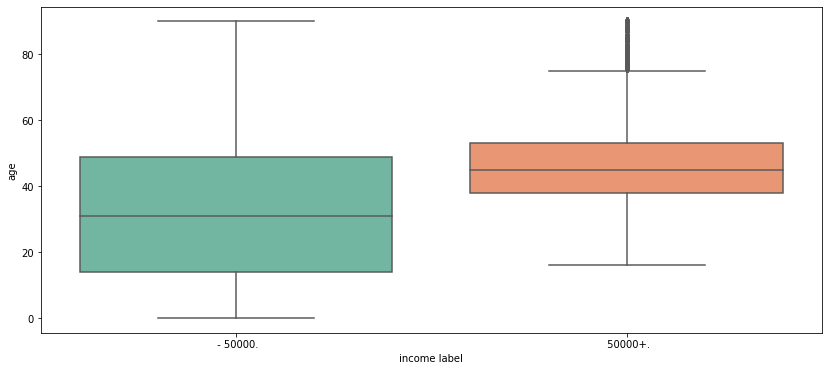

In [44]:
fig = plt.figure(figsize=(14,6))
sns.boxplot(y="age", x="income label", data=data_train_pandas, palette="Set2")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='income label', ylabel='weeks worked in year'>

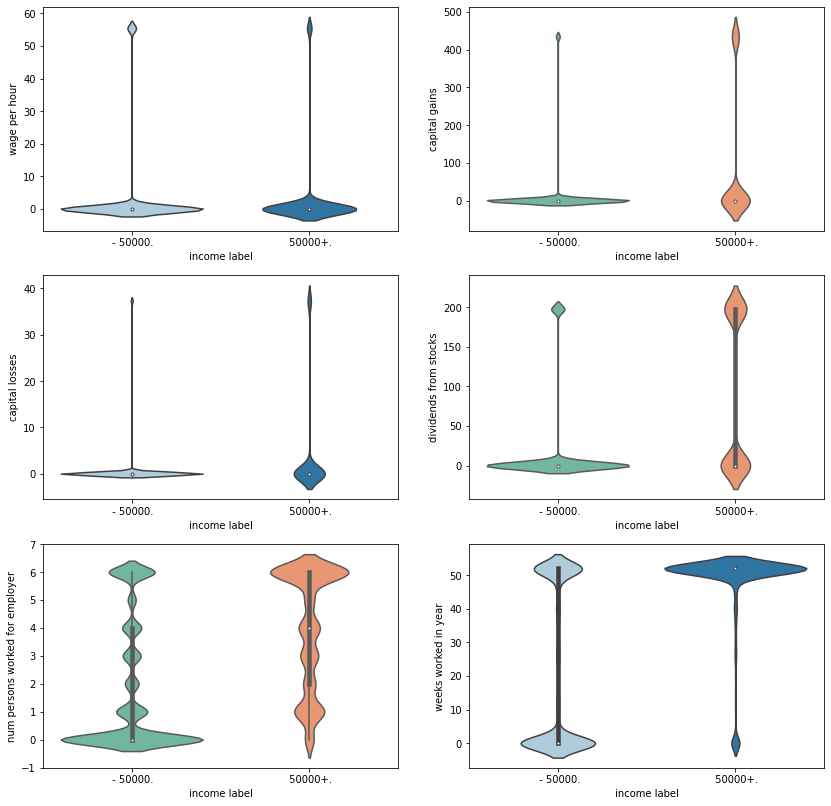

In [45]:
fig,axes = plt.subplots(3,2, figsize=(14,14))

sns.violinplot(y="wage per hour", x="income label", data=data_train_pandas, ax=axes[0][0], palette="Paired")
sns.violinplot(y="capital gains", x="income label", data=data_train_pandas, ax=axes[0][1], palette="Set2")
sns.violinplot(y="capital losses", x="income label", data=data_train_pandas, ax=axes[1][0], palette="Paired")
sns.violinplot(y="dividends from stocks", x="income label", data=data_train_pandas, ax=axes[1][1], palette="Set2")
sns.violinplot(y="num persons worked for employer", x="income label", data=data_train_pandas, ax=axes[2][0], palette="Set2")
sns.violinplot(y="weeks worked in year", x="income label", data=data_train_pandas, ax=axes[2][1], palette="Paired")

### Target - income label - encoding

### 6. Create a binary target variable to predict income above 50k and below 50k. 

We have a lot of categorical variables in this dataset. One of them is target. 

To display and show more relations between categorical atributes and dependent variable, first I encode **income label**. 

Then I still continue working on **point 5.**

In [46]:
data_train_pandas['income label'].value_counts()

 - 50000.    187141
 50000+.      12382
Name: income label, dtype: int64

In [47]:
le = LabelEncoder()
data_train_pandas['income label'] = le.fit_transform(data_train_pandas['income label'].astype(str)) 
data_train_pandas['income label'].value_counts()

0    187141
1     12382
Name: income label, dtype: int64

In [48]:
data_test_pandas['income label'].value_counts()

 - 50000.    93576
 50000+.      6186
Name: income label, dtype: int64

In [49]:
le = LabelEncoder()
data_test_pandas['income label'] = le.fit_transform(data_test_pandas['income label'].astype(str)) 
data_test_pandas['income label'].value_counts()

0    93576
1     6186
Name: income label, dtype: int64

#### An exploration and vizualization for categorical variables. 

I will analyse step by step, variable by variable the relations between them. 

In [50]:
data_train_pandas.loc[:5, ['class of worker','education', 'enrolled in edu inst last wk', 'marital status']]

,class of worker,education,enrolled in edu inst last wk,marital status
0,Not in universe,High school graduate,Not in universe,Widowed
1,Self-employed-not incorporated,Some college but no degree,Not in universe,Divorced
2,Not in universe,10th grade,High school,Never married
3,Not in universe,Children,Not in universe,Never married
4,Not in universe,Children,Not in universe,Never married
5,Private,Some college but no degree,Not in universe,Married-civilian spouse present


In [51]:
data_train_pandas['class of worker'].value_counts()

 Not in universe                   100245
 Private                            72028
 Self-employed-not incorporated      8445
 Local government                    7784
 State government                    4227
 Self-employed-incorporated          3265
 Federal government                  2925
 Never worked                         439
 Without pay                          165
Name: class of worker, dtype: int64

In [52]:
data_train_pandas['education'].value_counts()

 High school graduate                      48407
 Children                                  47422
 Some college but no degree                27820
 Bachelors degree(BA AB BS)                19865
 7th and 8th grade                          8007
 10th grade                                 7557
 11th grade                                 6876
 Masters degree(MA MS MEng MEd MSW MBA)     6541
 9th grade                                  6230
 Associates degree-occup /vocational        5358
 Associates degree-academic program         4363
 5th or 6th grade                           3277
 12th grade no diploma                      2126
 1st 2nd 3rd or 4th grade                   1799
 Prof school degree (MD DDS DVM LLB JD)     1793
 Doctorate degree(PhD EdD)                  1263
 Less than 1st grade                         819
Name: education, dtype: int64

In [53]:
data_train_pandas['enrolled in edu inst last wk'].value_counts()

 Not in universe          186943
 High school                6892
 College or university      5688
Name: enrolled in edu inst last wk, dtype: int64

In [54]:
data_train_pandas['marital status'].value_counts()

 Never married                      86485
 Married-civilian spouse present    84222
 Divorced                           12710
 Widowed                            10463
 Separated                           3460
 Married-spouse absent               1518
 Married-A F spouse present           665
Name: marital status, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='income label', ylabel='education'>

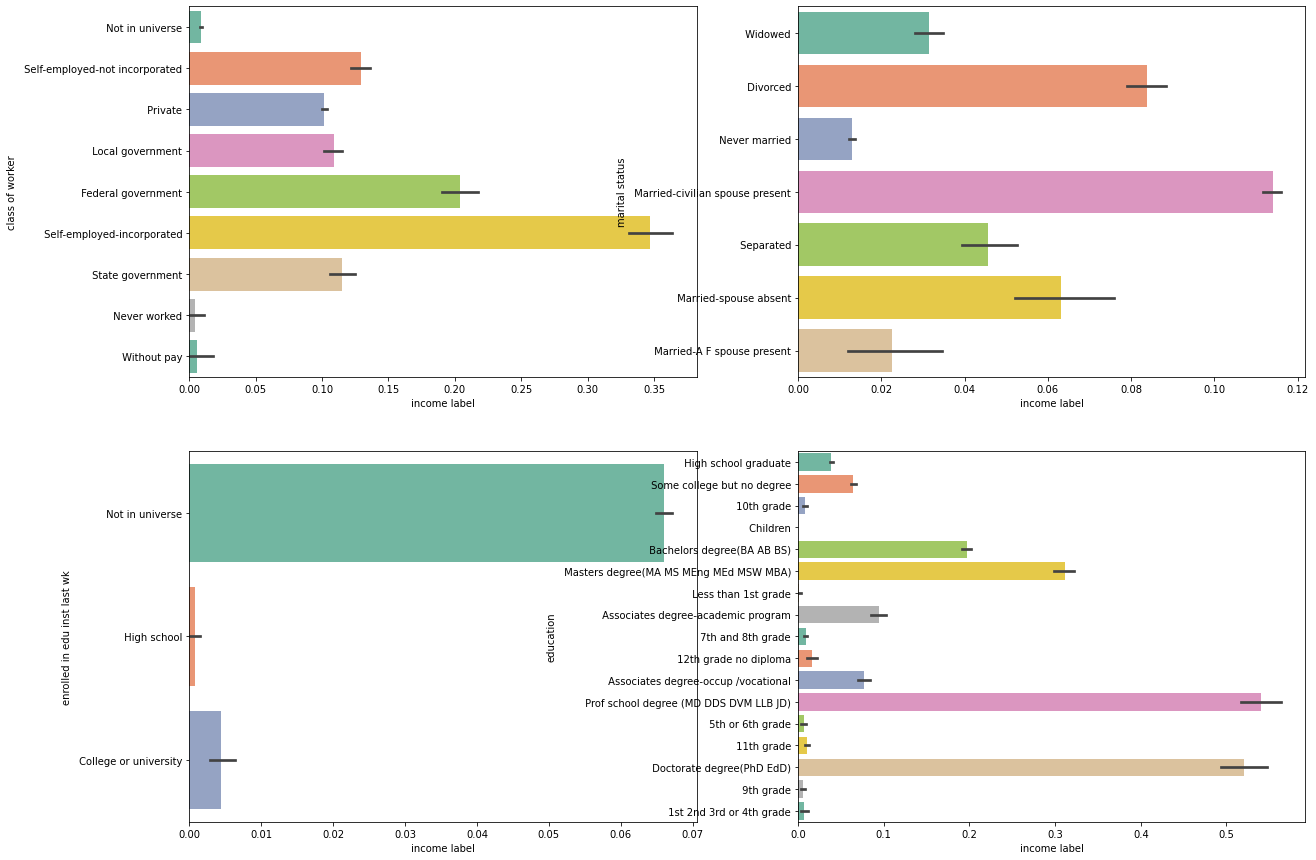

In [55]:
fig,axes = plt.subplots(2,2, figsize=(20,15))
sns.barplot(y='class of worker', x='income label', data=data_train_pandas, ax=axes[0][0], palette="Set2")
sns.barplot(y='marital status', x='income label', data=data_train_pandas, ax=axes[0][1], palette="Set2")
sns.barplot(y='enrolled in edu inst last wk', x='income label', data=data_train_pandas, ax=axes[1][0], palette="Set2")
sns.barplot(y='education', x='income label', data=data_train_pandas, ax=axes[1][1], palette="Set2")

#### Droping variables
The variable **enrolled in edu inst last wk** probably should be drop, because in most of rows there is not the specific value. 

In [56]:
data_train_pandas = data_train_pandas.drop(['enrolled in edu inst last wk'], axis = 1)

data_test_pandas = data_test_pandas.drop(['enrolled in edu inst last wk'], axis = 1)

In [57]:
data_train_pandas.loc[:10, ['industry code','occupation code','major industry code','major occupation code']]

,industry code,occupation code,major industry code,major occupation code
0,0,0,Not in universe or children,Not in universe
1,4,34,Construction,Precision production craft & repair
2,0,0,Not in universe or children,Not in universe
3,0,0,Not in universe or children,Not in universe
4,0,0,Not in universe or children,Not in universe
5,40,10,Entertainment,Professional specialty
6,34,3,Finance insurance and real estate,Executive admin and managerial
7,4,40,Construction,Handlers equip cleaners etc
8,43,26,Education,Adm support including clerical
9,4,37,Construction,Machine operators assmblrs & inspctrs


In [58]:
data_train_pandas['industry code'].value_counts()

 0     100684
 33     17070
 43      8283
 4       5984
 42      4683
 45      4482
 29      4209
 37      4022
 41      3964
 32      3596
 35      3380
 39      2937
 34      2765
 44      2549
 2       2196
 11      1764
 50      1704
 40      1651
 47      1644
 38      1629
 24      1503
 12      1350
 19      1346
 30      1181
 31      1178
 25      1084
 9        993
 22       952
 36       945
 13       899
 1        827
 48       652
 27       626
 49       610
 3        563
 21       559
 6        554
 5        553
 8        550
 16       539
 23       525
 18       483
 15       452
 7        422
 14       295
 46       187
 17       157
 28       143
 26       127
 51        36
 20        32
 10         4
Name: industry code, dtype: int64

In [59]:
data_train_pandas['major industry code'].value_counts()

 Not in universe or children            100684
 Retail trade                            17070
 Manufacturing-durable goods              9015
 Education                                8283
 Manufacturing-nondurable goods           6897
 Finance insurance and real estate        6145
 Construction                             5984
 Business and repair services             5651
 Medical except hospital                  4683
 Public administration                    4610
 Other professional services              4482
 Transportation                           4209
 Hospital services                        3964
 Wholesale trade                          3596
 Agriculture                              3023
 Personal services except private HH      2937
 Social services                          2549
 Entertainment                            1651
 Communications                           1181
 Utilities and sanitary services          1178
 Private household services                945
 Mining      

In [60]:
data_train_pandas['occupation code'].value_counts()

 0     100684
 2       8756
 26      7887
 19      5413
 29      5105
 36      4145
 34      4025
 10      3683
 16      3445
 23      3392
 12      3340
 33      3325
 3       3195
 35      3168
 38      3003
 31      2699
 32      2398
 37      2234
 8       2151
 42      1918
 30      1897
 24      1847
 17      1771
 28      1661
 44      1592
 41      1592
 43      1382
 4       1364
 13      1271
 18      1083
 39      1017
 14       932
 5        855
 15       815
 27       780
 25       767
 9        738
 7        731
 11       637
 40       617
 1        544
 21       533
 6        441
 22       411
 45       172
 20        71
 46        36
Name: occupation code, dtype: int64

In [61]:
data_train_pandas['major occupation code'].value_counts()

 Not in universe                          100684
 Adm support including clerical            14837
 Professional specialty                    13940
 Executive admin and managerial            12495
 Other service                             12099
 Sales                                     11783
 Precision production craft & repair       10518
 Machine operators assmblrs & inspctrs      6379
 Handlers equip cleaners etc                4127
 Transportation and material moving         4020
 Farming forestry and fishing               3146
 Technicians and related support            3018
 Protective services                        1661
 Private household services                  780
 Armed Forces                                 36
Name: major occupation code, dtype: int64

#### Droping variables

I decided to drop the variables **'industry code','occupation code','major industry code','major occupation code'** due to high class imbalance (over half have non specific value). 

In [62]:
data_train_pandas = data_train_pandas.drop(['industry code','occupation code','major industry code','major occupation code'], axis = 1)

data_test_pandas = data_test_pandas.drop(['industry code','occupation code','major industry code','major occupation code'], axis = 1)

In [63]:
data_train_pandas.iloc[:5, 5:11]

,mace,hispanic Origin,sex,member of a labor union,reason for unemployment,full or part time employment stat
0,White,All other,Female,Not in universe,Not in universe,Not in labor force
1,White,All other,Male,Not in universe,Not in universe,Children or Armed Forces
2,Asian or Pacific Islander,All other,Female,Not in universe,Not in universe,Not in labor force
3,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces
4,White,All other,Female,Not in universe,Not in universe,Children or Armed Forces


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='income label', ylabel='full or part time employment stat'>

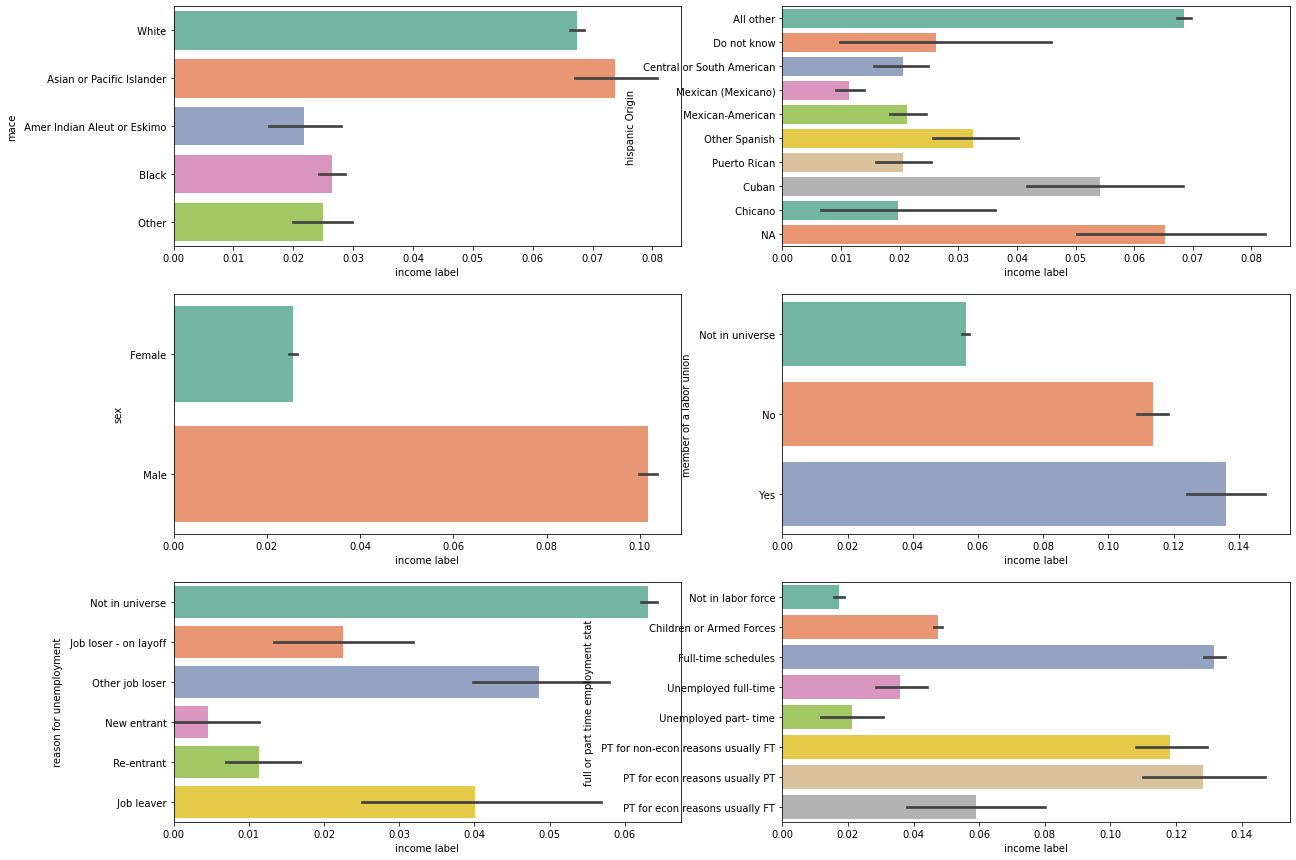

In [64]:
fig,axes = plt.subplots(3,2, figsize=(20,15))
sns.barplot(y='mace', x='income label', data=data_train_pandas, ax=axes[0][0], palette="Set2")
sns.barplot(y='hispanic Origin', x='income label', data=data_train_pandas, ax=axes[0][1], palette="Set2")
sns.barplot(y='sex', x='income label', data=data_train_pandas, ax=axes[1][0], palette="Set2")
sns.barplot(y='member of a labor union', x='income label', data=data_train_pandas, ax=axes[1][1], palette="Set2")
sns.barplot(y='reason for unemployment', x='income label', data=data_train_pandas, ax=axes[2][0], palette="Set2")
sns.barplot(y='full or part time employment stat', x='income label', data=data_train_pandas, ax=axes[2][1], palette="Set2")

In [65]:
data_train_pandas['reason for unemployment'].value_counts()

 Not in universe          193453
 Other job loser            2038
 Re-entrant                 2019
 Job loser - on layoff       976
 Job leaver                  598
 New entrant                 439
Name: reason for unemployment, dtype: int64

In [66]:
data_train_pandas['member of a labor union'].value_counts()

 Not in universe    180459
 No                  16034
 Yes                  3030
Name: member of a labor union, dtype: int64

#### Droping variables

I decided to drop the variables **'member of a labor union','reason for unemployment'** due to high class imbalance (over half have non specific value). 

In [67]:
data_train_pandas = data_train_pandas.drop(['member of a labor union','reason for unemployment'], axis = 1)

data_test_pandas = data_test_pandas.drop(['member of a labor union','reason for unemployment'], axis = 1)

In [68]:
data_train_pandas.iloc[:5, 12:24]

,tax filer status,region of previous residence,state of previous residence,detailed household and family stat,detailed household summary in household,migration code-change in msa,migration code-change in reg,migration code-move within reg,live in this house 1 year ago,migration prev res in sunbelt,num persons worked for employer,family members under 18
0,Nonfiler,Not in universe,Not in universe,Other Rel 18+ ever marr not in subfamily,Other relative of householder,?,?,?,Not in universe under 1 year old,?,0.0,Not in universe
1,Head of household,South,Arkansas,Householder,Householder,MSA to MSA,Same county,Same county,No,Yes,1.0,Not in universe
2,Nonfiler,Not in universe,Not in universe,Child 18+ never marr Not in a subfamily,Child 18 or older,?,?,?,Not in universe under 1 year old,?,0.0,Not in universe
3,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0.0,Both parents present
4,Nonfiler,Not in universe,Not in universe,Child <18 never marr not in subfamily,Child under 18 never married,Nonmover,Nonmover,Nonmover,Yes,Not in universe,0.0,Both parents present


In [69]:
data_train_pandas['tax filer status'].value_counts()

 Nonfiler                        75094
 Joint both under 65             67383
 Single                          37421
 Joint both 65+                   8332
 Head of household                7426
 Joint one under 65 & one 65+     3867
Name: tax filer status, dtype: int64

In [70]:
data_train_pandas['region of previous residence'].value_counts()

 Not in universe    183750
 South                4889
 West                 4074
 Midwest              3575
 Northeast            2705
 Abroad                530
Name: region of previous residence, dtype: int64

In [71]:
data_train_pandas['state of previous residence'].value_counts()

 Not in universe         183750
 California                1714
 Utah                      1063
 Florida                    849
 North Carolina             812
 ?                          708
 Abroad                     671
 Oklahoma                   626
 Minnesota                  576
 Indiana                    533
 North Dakota               499
 New Mexico                 463
 Michigan                   441
 Alaska                     290
 Kentucky                   244
 Arizona                    243
 New Hampshire              242
 Wyoming                    241
 Colorado                   239
 Oregon                     236
 West Virginia              231
 Georgia                    227
 Montana                    226
 Alabama                    216
 Ohio                       211
 Texas                      209
 Arkansas                   205
 Mississippi                204
 Tennessee                  202
 Pennsylvania               199
 New York                   195
 Louisia

In [72]:
data_train_pandas['detailed household and family stat'].value_counts()

 Householder                                        53248
 Child <18 never marr not in subfamily              50326
 Spouse of householder                              41695
 Nonfamily householder                              22213
 Child 18+ never marr Not in a subfamily            12030
 Secondary individual                                6122
 Other Rel 18+ ever marr not in subfamily            1956
 Grandchild <18 never marr child of subfamily RP     1868
 Other Rel 18+ never marr not in subfamily           1728
 Grandchild <18 never marr not in subfamily          1066
 Child 18+ ever marr Not in a subfamily              1013
 Child under 18 of RP of unrel subfamily              732
 RP of unrelated subfamily                            685
 Child 18+ ever marr RP of subfamily                  671
 Other Rel 18+ ever marr RP of subfamily              656
 Other Rel <18 never marr child of subfamily RP       656
 Other Rel 18+ spouse of subfamily RP                 638
 Child 18+ nev

In [73]:
data_train_pandas['detailed household summary in household'].value_counts()

 Householder                             75475
 Child under 18 never married            50426
 Spouse of householder                   41709
 Child 18 or older                       14430
 Other relative of householder            9703
 Nonrelative of householder               7601
 Group Quarters- Secondary individual      132
 Child under 18 ever married                47
Name: detailed household summary in household, dtype: int64

In [74]:
data_train_pandas['migration code-change in msa'].value_counts()

 ?                   99696
 Nonmover            82538
 MSA to MSA          10601
 NonMSA to nonMSA     2811
 Not in universe      1516
 MSA to nonMSA         790
 NonMSA to MSA         615
 Abroad to MSA         453
 Not identifiable      430
 Abroad to nonMSA       73
Name: migration code-change in msa, dtype: int64

In [75]:
data_train_pandas['migration code-change in reg'].value_counts()

 ?                                 99696
 Nonmover                          82538
 Same county                        9812
 Different county same state        2797
 Not in universe                    1516
 Different region                   1178
 Different state same division       991
 Abroad                              530
 Different division same region      465
Name: migration code-change in reg, dtype: int64

In [76]:
data_train_pandas['migration code-move within reg'].value_counts()

 ?                               99696
 Nonmover                        82538
 Same county                      9812
 Different county same state      2797
 Not in universe                  1516
 Different state in South          973
 Different state in West           679
 Different state in Midwest        551
 Abroad                            530
 Different state in Northeast      431
Name: migration code-move within reg, dtype: int64

In [77]:
data_train_pandas['live in this house 1 year ago'].value_counts()

 Not in universe under 1 year old    101212
 Yes                                  82538
 No                                   15773
Name: live in this house 1 year ago, dtype: int64

In [78]:
data_train_pandas['migration prev res in sunbelt'].value_counts()

 ?                  99696
 Not in universe    84054
 No                  9987
 Yes                 5786
Name: migration prev res in sunbelt, dtype: int64

In [79]:
data_train_pandas['family members under 18'].value_counts()

 Not in universe           144232
 Both parents present       38983
 Mother only present        12772
 Father only present         1883
 Neither parent present      1653
Name: family members under 18, dtype: int64

#### Droping variables

I decided to drop the variables **'region of previous residence','state of previous residence','detailed household and family stat','migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg','live in this house 1 year ago', 'migration prev res in sunbelt'** due to high class imbalance (over half have non specific value). 

In [80]:
data_train_pandas = data_train_pandas.drop(['region of previous residence','state of previous residence','detailed household and family stat',
                              'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg',
                              'live in this house 1 year ago', 'migration prev res in sunbelt'], axis = 1)

data_test_pandas = data_test_pandas.drop(['region of previous residence','state of previous residence','detailed household and family stat',
                              'migration code-change in msa', 'migration code-change in reg', 'migration code-move within reg',
                              'live in this house 1 year ago', 'migration prev res in sunbelt'], axis = 1)

In [81]:
data_train_pandas.iloc[:5, 16:25]

,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year
0,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0.0,95
1,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52.0,94
2,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0.0,95
3,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,94
4,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,0,0.0,94


In [82]:
data_train_pandas['own business or self employed'].value_counts()

 0    180672
 2     16153
 1      2698
Name: own business or self employed, dtype: int64

In [83]:
data_train_pandas["fill inc questionnaire for veteran's admin"].value_counts()

 Not in universe    197539
 No                   1593
 Yes                   391
Name: fill inc questionnaire for veteran's admin, dtype: int64

In [84]:
data_train_pandas['veterans benefits'].value_counts()

 2    150130
 0     47409
 1      1984
Name: veterans benefits, dtype: int64

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:xlabel='income label', ylabel='citizenship'>

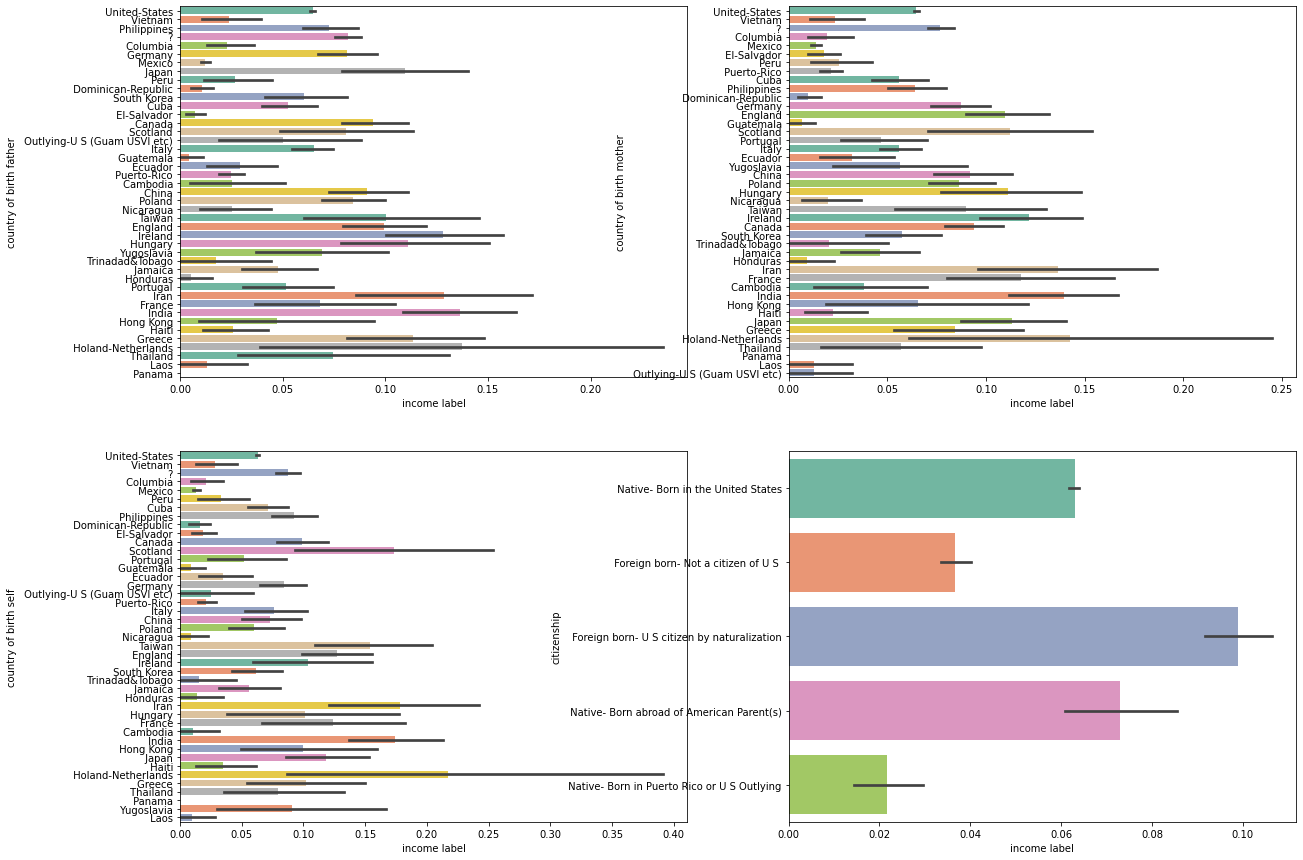

In [85]:
fig,axes = plt.subplots(2,2, figsize=(20,15))
sns.barplot(y='country of birth father', x='income label', data=data_train_pandas, ax=axes[0][0], palette="Set2")
sns.barplot(y='country of birth mother', x='income label', data=data_train_pandas, ax=axes[0][1], palette="Set2")
sns.barplot(y='country of birth self', x='income label', data=data_train_pandas, ax=axes[1][0], palette="Set2")
sns.barplot(y='citizenship', x='income label', data=data_train_pandas, ax=axes[1][1], palette="Set2")

#### Droping variables

I decided to drop the variables **'country of birth father','country of birth mother'**, because they are very similar to variable 'country of birth self', and to drop **'own business or self employed',"fill inc questionnaire for veteran's admin", 'veterans benefits'** due to high class imbalance (over half have non specific value). 

In [86]:
data_train_pandas = data_train_pandas.drop(['country of birth father','country of birth mother', 'own business or self employed',
                              "fill inc questionnaire for veteran's admin", 'veterans benefits'], axis = 1)

data_test_pandas = data_test_pandas.drop(['country of birth father','country of birth mother', 'own business or self employed',
                              "fill inc questionnaire for veteran's admin", 'veterans benefits'], axis = 1)

In [87]:
data_train_pandas.columns

Index(['age', 'class of worker', 'education', 'wage per hour',
       'marital status', 'mace', 'hispanic Origin', 'sex',
       'full or part time employment stat', 'capital gains', 'capital losses',
       'dividends from stocks', 'tax filer status',
       'detailed household summary in household',
       'num persons worked for employer', 'family members under 18',
       'country of birth self', 'citizenship', 'weeks worked in year', 'year',
       'income label'],
      dtype='object')

### Feauture selection

7. Select the most promising features **without using any ML model** (assume that dataset contains many features, and you cannot train a model on all of them). 

**Hint:** you may use some heuristics, significance tests etc. to select the predictive variables. You may not rely on model-based feature reduction techniques like Stepwise selection, Regularization. 

The goal here is to not rely on modeling algorithms to select features, as this may be very costly.

Sources: https://machinelearningmastery.com/feature-selection-with-real-and-categorical-data/

### Statistics for Filter-Based Feature Selection Methods

#### Numerical Inputs and Categorical Output

#### Correlation

In [88]:
corr = data_train_pandas.corr()
corr

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year,income label
age,1.000000,0.024806,0.123009,0.061409,0.238305,0.140887,0.206181,0.135720
wage per hour,0.024806,1.000000,0.005048,0.005431,0.001356,0.212444,0.220388,-0.013075
capital gains,0.123009,0.005048,1.000000,-0.027692,0.113133,0.103489,0.130700,0.215101
capital losses,0.061409,0.005431,-0.027692,1.000000,0.066073,0.089484,0.105416,0.138943
dividends from stocks,0.238305,0.001356,0.113133,0.066073,1.000000,0.147922,0.160222,0.269917
num persons worked for employer,0.140887,0.212444,0.103489,0.089484,0.147922,1.000000,0.747302,0.222684
weeks worked in year,0.206181,0.220388,0.130700,0.105416,0.160222,0.747302,1.000000,0.262316
income label,0.135720,-0.013075,0.215101,0.138943,0.269917,0.222684,0.262316,1.000000


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<AxesSubplot:>

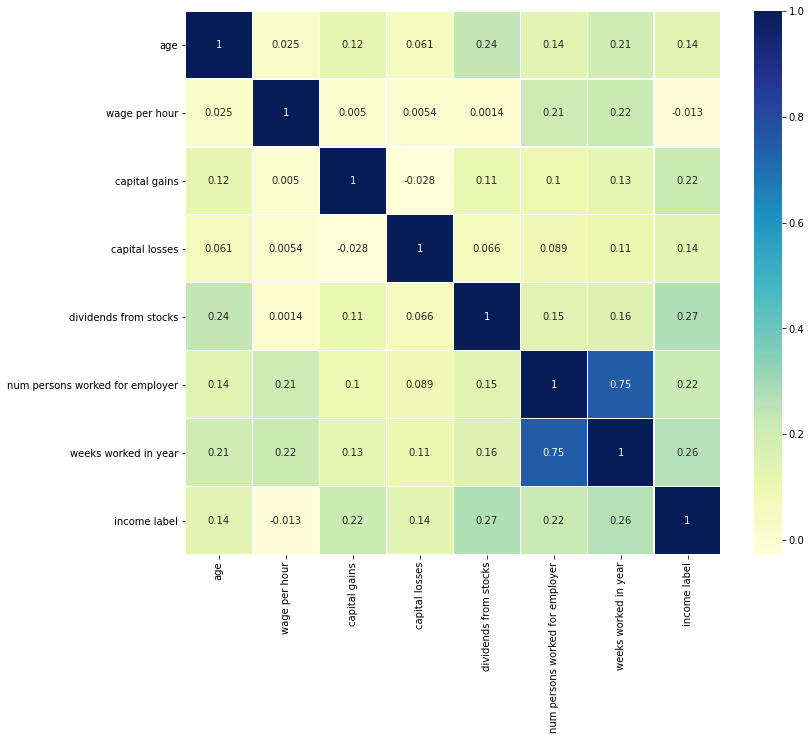

In [89]:
plt.figure(figsize=(12,10))
sns.heatmap(corr, annot=True, cmap="YlGnBu", linewidth=0.1, 
            xticklabels=corr.columns, yticklabels=corr.columns)

#### ANOVA

In [90]:
X = data_train_pandas[['age','wage per hour','capital gains','capital losses',
                       'dividends from stocks','num persons worked for employer','weeks worked in year']]
X

,age,wage per hour,capital gains,capital losses,dividends from stocks,num persons worked for employer,weeks worked in year
0,73.0,0.0,0.000000,0.0,0.000000,0.0,0.0
1,58.0,0.0,0.000000,0.0,0.000000,1.0,52.0
2,18.0,0.0,0.000000,0.0,0.000000,0.0,0.0
3,9.0,0.0,0.000000,0.0,0.000000,0.0,0.0
4,10.0,0.0,0.000000,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...
199518,87.0,0.0,0.000000,0.0,0.000000,0.0,0.0
199519,65.0,0.0,434.719055,0.0,197.529495,1.0,52.0
199520,47.0,0.0,0.000000,0.0,197.529495,6.0,52.0
199521,16.0,0.0,0.000000,0.0,0.000000,0.0,0.0


In [91]:
y = data_train_pandas['income label']
y

0         0
1         0
2         0
3         0
4         0
         ..
199518    0
199519    0
199520    0
199521    0
199522    0
Name: income label, Length: 199523, dtype: int64

In [92]:
# define feature selection
fs = SelectKBest(score_func=f_classif, k=3)

# apply feature selection
X_selected = fs.fit_transform(X, y)

print(X_selected.shape)

(199523, 3)


In [93]:
X_selected= X.columns[(fs.get_support())]
X_selected

Index(['dividends from stocks', 'num persons worked for employer',
       'weeks worked in year'],
      dtype='object')

#### Droping variables

Due to correlation or Anova test I decided to drop that variables **'age','wage per hour','capital gains','capital losses'**.

In [94]:
data_train_pandas = data_train_pandas.drop(['age','wage per hour','capital gains','capital losses'], axis = 1)

data_test_pandas = data_test_pandas.drop(['age','wage per hour','capital gains','capital losses'], axis = 1)

In [95]:
# data_train_pandas

### Chi-Square Test of Independence

#### Categorical Inputs and Categorical Output

Null Hypothesis (H0): There is **no relationship** between the variables

Alternative Hypothesis (H1): There is a relationship between variables

I will test the relationship between variables and target. As common we choose p-value level to 0.05, as the p-value test result is more than 0.05 we fail to reject the Null Hypothesis. This means, there is no relationship between one varaiabe and target feature based on the Chi-Square test of independence.

In [96]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['class of worker']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 13542.953108827336, p-value: 0.0


In [97]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['education']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 30322.049718408773, p-value: 0.0


In [98]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['marital status']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 7794.867355272996, p-value: 0.0


In [99]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['mace']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 688.3644561763933, p-value: 1.1524072977587733e-147


In [100]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['hispanic Origin']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 939.1780526455786, p-value: 2.2319668275955093e-196


In [101]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['sex']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 4955.014384555804, p-value: 0.0


In [102]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['full or part time employment stat']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 5098.018909765274, p-value: 0.0


In [103]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['dividends from stocks']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 14532.61180740211, p-value: 0.0


In [104]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['tax filer status']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 10484.359945226299, p-value: 0.0


In [105]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['detailed household summary in household']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 10301.203726139938, p-value: 0.0


In [106]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['num persons worked for employer']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 11254.990570229671, p-value: 0.0


In [107]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['family members under 18']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 5054.768316168905, p-value: 0.0


In [108]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['country of birth self']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 739.3155802616321, p-value: 2.8419748913375844e-128


In [109]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['weeks worked in year']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 14873.534640165566, p-value: 0.0


In [110]:
chi_res = chi2_contingency(pd.crosstab(data_train_pandas['income label'], data_train_pandas['year']))

print('Chi2 Statistic: {}, p-value: {}'.format(chi_res[0], chi_res[1]))

Chi2 Statistic: 43.544260443764, p-value: 4.1447805727523245e-11


#### Chi Square test for all 

In [111]:
X_cat = data_train_pandas[['class of worker','education','marital status','mace','hispanic Origin',
                                   'sex','full or part time employment stat','dividends from stocks',
                                   'tax filer status','detailed household summary in household',
                                   'num persons worked for employer','family members under 18',
                                   'country of birth self','citizenship','weeks worked in year','year', 'income label']]
X_cat.columns

Index(['class of worker', 'education', 'marital status', 'mace',
       'hispanic Origin', 'sex', 'full or part time employment stat',
       'dividends from stocks', 'tax filer status',
       'detailed household summary in household',
       'num persons worked for employer', 'family members under 18',
       'country of birth self', 'citizenship', 'weeks worked in year', 'year',
       'income label'],
      dtype='object')

In [112]:
chi2 = []
for i in X_cat:
    if chi2_contingency(pd.crosstab(X_cat['income label'], X_cat[i]))[1] < 0.05:
        chi2.append('Reject H0')
    else:
        chi2.append('Fail to Reject Null Hypothesis (H0)')

data_chi2 = pd.DataFrame(data = [X_cat.columns, chi2] 
             ).T 
data_chi2.columns = ['Column', 'Hypothesis']
print(data_chi2)  

                                     Column Hypothesis
0                           class of worker  Reject H0
1                                 education  Reject H0
2                            marital status  Reject H0
3                                      mace  Reject H0
4                           hispanic Origin  Reject H0
5                                       sex  Reject H0
6         full or part time employment stat  Reject H0
7                     dividends from stocks  Reject H0
8                          tax filer status  Reject H0
9   detailed household summary in household  Reject H0
10          num persons worked for employer  Reject H0
11                  family members under 18  Reject H0
12                    country of birth self  Reject H0
13                              citizenship  Reject H0
14                     weeks worked in year  Reject H0
15                                     year  Reject H0
16                             income label  Reject H0


In [113]:
final_columns = data_train_pandas.columns
final_columns

Index(['class of worker', 'education', 'marital status', 'mace',
       'hispanic Origin', 'sex', 'full or part time employment stat',
       'dividends from stocks', 'tax filer status',
       'detailed household summary in household',
       'num persons worked for employer', 'family members under 18',
       'country of birth self', 'citizenship', 'weeks worked in year', 'year',
       'income label'],
      dtype='object')

### 8. Should the raw model dataset be randomly distributed to Train/Test before or after identifying the most predictive features?

In my opinion, the dataset should be split into Train/Test datasets before performing feature engineering. If the datasets are split before, we have to make sure that each data tranposition will be done in both the training and test datasets. This creates a lot more work for the data scientist. 

### 9. Perform any feature engineering and explain the reasons behind.  e.g. New features from existing, re-grouping categorical variable categories, meaningful encoding, binning etc.

I plan to transform new features from existing, by grouping. For example: 'weeks worked in year' and 'country of birth self'. In context to guestion 8, I have to do the same steps in feature engineering in both datasets: Train and Test 

In [114]:
# data_train_pandas['weeks worked in year'].value_counts()

<AxesSubplot:>

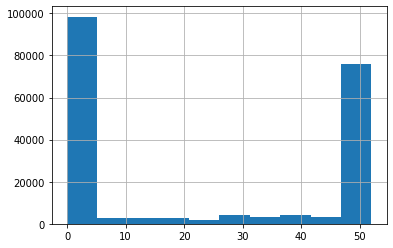

In [115]:
data_train_pandas['weeks worked in year'].hist()

In [116]:
def work_in_year (row):
    if row['weeks worked in year'] < 4:
        return 'up to a month'
    if row['weeks worked in year'] < 12:
        return 'up to a quarter'
    if row['weeks worked in year'] < 27:
        return 'half a year'
    if row['weeks worked in year'] < 52:
        return 'up to a year'
    if row['weeks worked in year'] >= 52:
        return 'permanent'
    
data_train_pandas['weeks'] = data_train_pandas.apply(lambda row: work_in_year(row), axis=1)    
data_train_pandas[['weeks worked in year','weeks']]

,weeks worked in year,weeks
0,0.0,up to a month
1,52.0,permanent
2,0.0,up to a month
3,0.0,up to a month
4,0.0,up to a month
...,...,...
199518,0.0,up to a month
199519,52.0,permanent
199520,52.0,permanent
199521,0.0,up to a month


In [117]:
data_test_pandas['weeks'] = data_test_pandas.apply(lambda row: work_in_year(row), axis=1) 
data_test_pandas[['weeks worked in year','weeks']]

,weeks worked in year,weeks
0,12.0,half a year
1,26.0,half a year
2,0.0,up to a month
3,52.0,permanent
4,50.0,up to a year
...,...,...
99757,0.0,up to a month
99758,52.0,permanent
99759,52.0,permanent
99760,52.0,permanent


In [118]:
# data_train_pandas['country of birth self'].value_counts()

<AxesSubplot:>

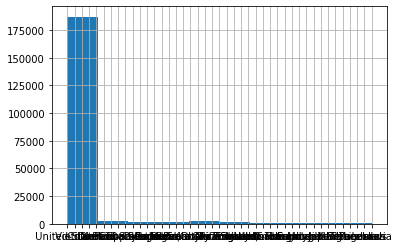

In [119]:
data_train_pandas['country of birth self'].hist()

In [120]:
europe = ['England','France','Germany','Greece','Holand-Netherlands',
          'Hungary',' Ireland',' Italy','Poland','Portugal',' Scotland','Yugoslavia']

asia = ['Cambodia','China','Hong Kong','India','Iran','Japan',
        'Laos','Philippines','South Korea','Taiwan','Thailand','Vietnam']

north_america = ['Canada','Cuba','Dominican-Republic','El-Salvador','Guatemala','Haiti',
                 'Honduras','Jamaica','Mexico','Nicaragua','Outlying-U S (Guam USVI etc)',
                 'Panama','Puerto-Rico','Trinadad&Tobago']       
other = ['?']

south_america = ['Columbia','Ecuador','Peru']

unitet_states = ['United-States']

I decided to group the countries by continents. Of course, you could think about and choose another measure of clustering, 
such as economic level, but I chose this division because 89% there is teh US and the rest it is a lot of fragmented countries from all over the world. 

In [121]:
d = {'Europe':europe,
     'Asia':asia,
     'North America':north_america,
     'South America':south_america,
     'United-States':unitet_states
    }

d1 = {x: k for k,v in d.items() for x in v}

data_train_pandas['continent'] = (data_train_pandas['country of birth self']
                                     .str.strip()
                                     .map(d1)
                                     .fillna('Other'))

data_test_pandas['continent'] = (data_test_pandas['country of birth self']
                                     .str.strip()
                                     .map(d1)
                                     .fillna('Other'))

In [122]:
data_train_pandas[['country of birth self','continent']].sample(10)

,country of birth self,continent
176147,United-States,United-States
20412,France,Europe
178234,United-States,United-States
71149,United-States,United-States
166546,United-States,United-States
39175,United-States,United-States
13798,United-States,United-States
14804,United-States,United-States
39831,United-States,United-States
84959,United-States,United-States


#### Droping variables

After feature engineering I have to drop columns:'weeks worked in year' and 'country of birth self' 

In [123]:
data_train_pandas = data_train_pandas.drop(['weeks worked in year','country of birth self'], axis = 1)

data_test_pandas = data_test_pandas.drop(['weeks worked in year','country of birth self'], axis = 1)

In [124]:
data_train_pandas.columns

Index(['class of worker', 'education', 'marital status', 'mace',
       'hispanic Origin', 'sex', 'full or part time employment stat',
       'dividends from stocks', 'tax filer status',
       'detailed household summary in household',
       'num persons worked for employer', 'family members under 18',
       'citizenship', 'year', 'income label', 'weeks', 'continent'],
      dtype='object')

In [125]:
data_test_pandas.columns

Index(['class of worker', 'education', 'marital status', 'mace',
       'hispanic Origin', 'sex', 'full or part time employment stat',
       'dividends from stocks', 'tax filer status',
       'detailed household summary in household',
       'num persons worked for employer', 'family members under 18',
       'citizenship', 'year', 'income label', 'weeks', 'continent'],
      dtype='object')

#### Rename final columns

In [126]:
data_train_pandas.rename(columns={'class of worker': 'class', 'marital status': 'marital', 'hispanic Origin': 'hispanic', 
                                  'full or part time employment stat':'worktime','dividends from stocks':'dividends','tax filer status':'tax',
                                 'detailed household summary in household':'detailed', 'num persons worked for employer':'persons',
                                 'family members under 18':'under18','income label':'Target'}, inplace=True)

data_test_pandas.rename(columns={'class of worker': 'class', 'marital status': 'marital', 'hispanic Origin': 'hispanic', 
                                  'full or part time employment stat':'worktime','dividends from stocks':'dividends','tax filer status':'tax',
                                 'detailed household summary in household':'detailed', 'num persons worked for employer':'persons',
                                 'family members under 18':'under18','income label':'Target'}, inplace=True)

### 10. Choose a ML algorithm to build an acceptable predictive model in PySpark and explain the reasons for the selection of such algorithm.

In [127]:
spark_session = SparkSession.builder.master("local").appName("Question1").getOrCreate()

In [128]:
data_train_sp = spark_session.createDataFrame(data_train_pandas)
data_test_sp = spark_session.createDataFrame(data_test_pandas)

In [129]:
# data_train_sp.show()

In [130]:
# data_test_sp.show()

In [131]:
data_train_sp.printSchema()

root
 |-- class: string (nullable = true)
 |-- education: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- mace: string (nullable = true)
 |-- hispanic: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- worktime: string (nullable = true)
 |-- dividends: double (nullable = true)
 |-- tax: string (nullable = true)
 |-- detailed: string (nullable = true)
 |-- persons: double (nullable = true)
 |-- under18: string (nullable = true)
 |-- citizenship: string (nullable = true)
 |-- year: string (nullable = true)
 |-- Target: long (nullable = true)
 |-- weeks: string (nullable = true)
 |-- continent: string (nullable = true)



In [132]:
data_test_sp.printSchema()

root
 |-- class: string (nullable = true)
 |-- education: string (nullable = true)
 |-- marital: string (nullable = true)
 |-- mace: string (nullable = true)
 |-- hispanic: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- worktime: string (nullable = true)
 |-- dividends: double (nullable = true)
 |-- tax: string (nullable = true)
 |-- detailed: string (nullable = true)
 |-- persons: double (nullable = true)
 |-- under18: string (nullable = true)
 |-- citizenship: string (nullable = true)
 |-- year: string (nullable = true)
 |-- Target: long (nullable = true)
 |-- weeks: string (nullable = true)
 |-- continent: string (nullable = true)



#### Set up stages to Pipeline

In [133]:
stages = []

#### Indexing and One Hot Encoding

In [134]:
final_categorical=  ['class','education','marital','mace','hispanic','sex','worktime',
                     'tax','detailed','persons','under18','citizenship','year',
                     'Target','weeks','continent']

In [135]:
# train dataset 

indexed = data_train_sp

catIndex = []
for str_ in final_categorical:
    cat_ = str_ + 'Index' 
    indexer = StringIndexer(inputCol=str_, outputCol=cat_)
    indexed = indexer.fit(indexed).transform(indexed)
    catIndex.append(cat_)

In [136]:
# test dataset 

indexedTest = data_test_sp

catIndexTest = []
for str_ in final_categorical:
    cat_ = str_ + 'Index' 
    indexerTest = StringIndexer(inputCol=str_, outputCol=cat_)
    indexedTest = indexerTest.fit(indexedTest).transform(indexedTest)
    catIndexTest.append(cat_)

In [137]:
stages += [indexer]

In [138]:
# indexed.show(1)

In [139]:
# indexed.columns

In [140]:
# train dataset

catVec = [str_ + 'Vec' for str_ in final_categorical]

encoder = OneHotEncoder(inputCols=catIndex,
                        outputCols=catVec)
model = encoder.fit(indexed)
encoded = model.transform(indexed)

# encoded.show(1)

In [141]:
# test dataset

catVecTest = [str_ + 'Vec' for str_ in final_categorical]

encoderTest = OneHotEncoder(inputCols=catIndexTest,
                        outputCols=catVecTest)
modelTest = encoder.fit(indexedTest)
encodedTest = modelTest.transform(indexedTest)

# encoded.show(1)

In [142]:
stages += [encoder]

In [143]:
# encoded.columns

### Index the label column

In [144]:
label_stringIndexer = StringIndexer(
    inputCol= 'Target', 
    outputCol= 'label')

In [145]:
stages += [label_stringIndexer]

In [146]:
final_numerical = ['dividends']

In [147]:
encoded_categoricalVec= ['classVec','educationVec','maritalVec','maceVec',
                      'hispanicVec','sexVec','worktimeVec','taxVec', 
                      'detailedVec','personsVec','under18Vec','citizenshipVec',
                      'yearVec','TargetVec','weeksVec','continentVec']

### Assembling into Vectors

In [148]:
# train dataset

numeric_features = [col[0] for col in encoded.dtypes if 'string' not in col[1] and 'Target' not in col[1]]

assembler = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features")

output = assembler.transform(encoded)
# output.show(1)

# output.select("features").show(truncate=False)

In [149]:
stages += [assembler]

In [150]:
# test dataset

numeric_features = [col[0] for col in encodedTest.dtypes if 'string' not in col[1] and 'Target' not in col[1]]

assemblerTest = VectorAssembler(
    inputCols=numeric_features,
    outputCol="features")

outputTest = assemblerTest.transform(encodedTest)

### Scale features using Normalization

In [151]:
# train dataset

scaler = StandardScaler(inputCol = 'features', 
                        outputCol = 'scaledFeatures', 
                        withStd = True, 
                        withMean = True)

scalerModel = scaler.fit(output)
scaled_train = scalerModel.transform(output)

In [152]:
stages += [scaler]

In [153]:
# test dataset

scalerTest = StandardScaler(inputCol = 'features', 
                        outputCol = 'scaledFeatures', 
                        withStd = True, 
                        withMean = True)

scalerModelTest = scalerTest.fit(outputTest)
scaled_test = scalerModelTest.transform(outputTest)

In [154]:
# scaled_train.select('scaledFeatures').show(1,truncate=False)

In [155]:
# scaled_test.select('scaledFeatures').rdd.collect()[0]

#### Choose a ML Algorithm

I want to use Random Forest Classifier. 

In [156]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(labelCol='Target', 
                            featuresCol='scaledFeatures', numTrees=10)

In [157]:
stages += [classifier]

#### Create a Pipeline

In [158]:
pipeline = Pipeline(stages = [classifier])

### 11. Print the model performance measurements such as ROC, AUC, Confusion Matrix for both train and test data.

In [159]:
model = pipeline.fit(scaled_train)

prediction = model.transform(scaled_train)

In [160]:
ROC_eval = BinaryClassificationEvaluator(rawPredictionCol='prediction',
                                       labelCol='Target', metricName="areaUnderROC")

In [161]:
Train_AUC = ROC_eval.evaluate(prediction)
print('Train Area Under ROC is {}'.format(Train_AUC))

Train Area Under ROC is 1.0


In [162]:
predictionTest = model.transform(scaled_test)

In [163]:
Test_AUC = ROC_eval.evaluate(predictionTest)
print('Test Area Under ROC is {}'.format(Test_AUC))

Test Area Under ROC is 1.0


In [164]:
# Plot confusion matrix for the train set

y_true = prediction.select(['Target']).collect()
y_pred = prediction.select(['prediction']).collect()

print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    187141
           1       1.00      1.00      1.00     12382

    accuracy                           1.00    199523
   macro avg       1.00      1.00      1.00    199523
weighted avg       1.00      1.00      1.00    199523



### 12. Explain the steps taken to avoid model overfitting.

I didn't do additional steps to avoid overfitting. 
It is possible to reduce number of iterations and penalize tree size to prevent overfitting.

When the model is too complex, it can learn, then the model learns deviations that do not affect the real trend.

Two cases of overfitting:
1. High variance. The model error in the training data is much smaller than in the test data and there is a large gap:

Remedies:
- increasing the amount of training data
- reduction of the number of parameters, reduction of the algorithm complexity
- Cross-validation, bagging or increasing regularization

2. High bias. The model error in the training data is above an acceptable level.

Remedies:
- choosing a more complex model
- increasing parameters
- adding attributes
- reduction of regularization

### 13. What changes do you propose to make this modeling process more effective, if you are to train this in a cluster with 1,000 nodes, 300 million rows and 5,000 features in AWS?

Unfortunately, I have not worked in AWS before and I cannot judge what changes I should implement. The description of AWS tools and available functions shows that the entire process of building, training and implementing your own machine learning models on large data sets becomes faster and easier.

I am open to acquiring knowledge and broadening my skills.

In [165]:
spark.stop()